In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import csv
import math
import datetime
from scipy.stats import skew

In [224]:
# parsivel raw data processing

names = np.array(['Date', 'Time', 'Intensity of precipitation (mm/h)',
               'Precipitation since start (mm)', 'Weather code SYNOP WaWa', 'Weather code METAR/SPECI',
               'Weather code NWS', 'Radar reflectivity (dBz)', 'MOR Visibility (m)',
               'Signal amplitude of Laserband', 'Number of detected particles', 'Temperature in sensor (ºC)',
               'Heating current (A)', 'Sensor voltage (V)', 'Optics status',
               'Kinetic Energy', 'Snow intensity (mm/h)'])
names = np.append(names, ['%.0f' % x for x in np.arange(1, 1025)])
names = np.append(names, ['</SPECTRUM>'])

# add .csv to original Parsivel data file 
file_name = ('2022-10-10-02-24')
df = pd.read_csv(file_name, sep=';', names=names, parse_dates=[['Date', 'Time']], index_col=['Date_Time'],
                 dayfirst=True, infer_datetime_format=True,na_values=[''])

# remove the repeating column names
# use .copy() to avoid warning of SettingWithCopy
# df = df.drop(df[df.iloc[:, 0] == df.iloc[0, 0]].index).copy()
try:
    df = df.drop(index='Date Time')
except:
    pass

# remove the last column
df = df.drop(['</SPECTRUM>'], axis=1)

# convert data type
df.index = pd.to_datetime(df.index).tz_localize('Asia/Taipei')
df.loc[:, names[2]] = df.loc[:, names[2]].astype(float) # Intensity of precipitation (mm/h)

# replace <SPECTRUM> with the value of first DSD cell
df.loc[:, '1'] = df.loc[df.loc[:, '1'] != '<SPECTRUM>ZERO</SPECTRUM>', '1'].str[10:]

# fill NaN with 0.0, convert '' to float
df.loc[:,:] = df.loc[:,:].fillna(0.0)
df.loc[:, '1'] = pd.to_numeric(df.loc[:, '1'])

# resample by 1min
df = df.resample('1T', label='right', closed='right').sum()
pd.set_option('display.max_columns',None)

df.loc["2022-10-30 16:51:00+08:00"]

C:\Users\88690\AppData\Local\Temp\ipykernel_9800\702290285.py:14: DtypeWarning: Columns (1041) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name, sep=';', names=names, parse_dates=[['Date', 'Time']], index_col=['Date_Time'],
C:\Users\88690\AppData\Local\Temp\ipykernel_9800\702290285.py:37: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, '1'] = pd.to_numeric(df.loc[:, '1'])
C:\Users\88690\AppData\Local\Temp\ipykernel_9800\702290285.py:40: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = df.resample('1T', label='ri

Intensity of precipitation (mm/h)       12.875
Precipitation since start (mm)         806.670
Weather code SYNOP WaWa                474.000
Radar reflectivity (dBz)               152.442
MOR Visibility (m)                   18986.000
                                       ...    
1020                                     0.000
1021                                     0.000
1022                                     0.000
1023                                     0.000
1024                                     0.000
Name: 2022-10-30 16:51:00+08:00, Length: 1037, dtype: float64

In [213]:
speed_class = np.array([0.05, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95, 1.1, 1.3, 1.5, 1.7, 1.9,
               2.2, 2.6, 3.0, 3.4, 3.8, 4.4, 5.2, 6.0, 6.8, 7.6, 8.8, 10.4, 12.0, 13.6, 15.2, 17.6, 20.8])
diameter_class = np.array([0.062, 0.187, 0.312, 0.437, 0.562, 0.687, 0.812, 0.937, 1.062, 1.187, 1.375, 1.625, 1.875, 2.125, 2.375,
                  2.750, 3.250, 3.750, 4.250, 4.750, 5.500, 6.500, 7.500, 8.500, 9.500, 11.000, 13.000, 15.000, 17.000, 19.000, 21.500, 24.500])

# Extract data from a certain time period
start_time = "2022-10-30 00:00:00+08:00"
end_time = "2022-10-31 00:0:00+08:00"
data = df.loc[start_time:end_time]
data = data.iloc[:,13:1037]

# Initialize 'rmse' column with NaN values
# data["rmse"] = np.nan

df_rmse = pd.DataFrame(columns=['rmse'])

data

1    2    3    4    5    6    7    8    9   10  \
Date_Time                                                                     
2022-10-30 00:00:00+08:00  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2022-10-30 00:01:00+08:00  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2022-10-30 00:02:00+08:00  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2022-10-30 00:03:00+08:00  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2022-10-30 00:04:00+08:00  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
...                        ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
2022-10-30 23:56:00+08:00  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2022-10-30 23:57:00+08:00  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2022-10-30 23:58:00+08:00  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2022-10-30 23:59:00+08:00  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2022-10-31 00:00:00+08:00  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

                            11   12   13   14   15   16   17   18   19   20  \
Date_Time                                                                     
2022-10-30 00:00:00+08:00  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2022-10-30 00:01:00+08:00  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2022-10-30 00:02:00+08:00  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2022-10-30 00:03:00+08:00  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2022-10-30 00:04:00+08:00  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
...                        ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
2022-10-30 23:56:00+08:00  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2022-10-30 23:57:00+08:00  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2022-10-30 23:58:00+08:00  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2022-10-30 23:59:00+08:00  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2022-10-31 00:00:00+08:00  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

                            21   22   23   24   25   26   27   28   29   30  \
Date_Time                                                                     
2022-10-30 00:00:00+08:00  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2022-10-30 00:01:00+08:00  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2022-10-30 00:02:00+08:00  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2022-10-30 00:03:00+08:00  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2022-10-30 00:04:00+08:00  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
...                        ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
2022-10-30 23:56:00+08:00  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2022-10-30 23:57:00+08:00  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2022-10-30 23:58:00+08:00  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2022-10-30 23:59:00+08:00  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2022-10-31 00:00:00+08:00  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

                            31   32   33   34   35   36   37   38   39   40  \
Date_Time                                                                     
2022-10-30 00:00:00+08:00  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2022-10-30 00:01:00+08:00  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2022-10-30 00:02:00+08:00  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2022-10-30 00:03:00+08:00  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2022-10-30 00:04:00+08:00  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
...                        ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
2022-10-30 23:56:00+08:00  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2022-10-30 23:57:00+08:00  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2022-10-30 23:58:00+08:00  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2022-10-30 23:59:00+08:00  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 

In [215]:
# 使用时间部分作为for循环的迭代对象
for index, row in data.iterrows():

    # transform data into 32x32 matrix
    array = np.asarray(data.loc[index], dtype=int)
    mat = np.flip(array.reshape(32, 32), 0)
    drop = pd.DataFrame()

    # 循环遍历矩阵的每个元素
    for i in range(32):
        for j in range(32):
            # 获取矩阵元素的值
            value = mat[i][j]

            # 根据值重复构建直径和速度的数据列表
            diameter_list = [diameter_class[j]] * value
            speed_list = [speed_class[31-i]] * value

            # 将直径和速度的数据列表添加到DataFrame
            temp_drop = pd.DataFrame({'diameter': diameter_list, 'velocity': speed_list})

            # 将临时DataFrame添加到主DataFrame
            drop = pd.concat([drop, temp_drop], ignore_index=True)
    
    x = np.linspace(0, 25, 25)
    y = 9.65 - 10.43 * np.exp(-0.6 * x)
    y1 = 9.65 - 10.43 * np.exp(-0.6 * diameter_class[:])


    def mse(actual, pred):
        actual, pred = np.array(actual), np.array(pred)
        return np.square(np.subtract(actual, pred)).mean()


    def rmse(actual, pred):
        actual, pred = np.array(actual), np.array(pred)
        return np.sqrt(np.square(np.subtract(actual, pred)).mean())

    # print(drop["velocity"])
    rmse_value = rmse(y1, drop["velocity"])
    # df_rmse["rmse"] = [rmse_value]
    # df_rmse = df_rmse.append(rmse_value,ignore_index=True)
    
    # print(index, rmse_value)
    df_rmse.loc[index, ['rmse']] = rmse_value


df_rmse

[-0.39913206  0.32698318  1.00063188  1.62560506  2.20541986  2.74333927
  3.2423905   3.70538202  4.13491939  4.53341989  5.07920903  5.71588375
  6.26387477  6.735535    7.14149673  7.64691945  8.16608143  8.55068609
  8.83560822  9.04668373  9.26530856  9.43887686  9.53413317  9.58641093
  9.61510158  9.63581136  9.64572646  9.64871284  9.64961231  9.64988323
  9.64997395  9.64999569]


ValueError: operands could not be broadcast together with shapes (32,) (56,) 

In [193]:
df_rmse

,rmse


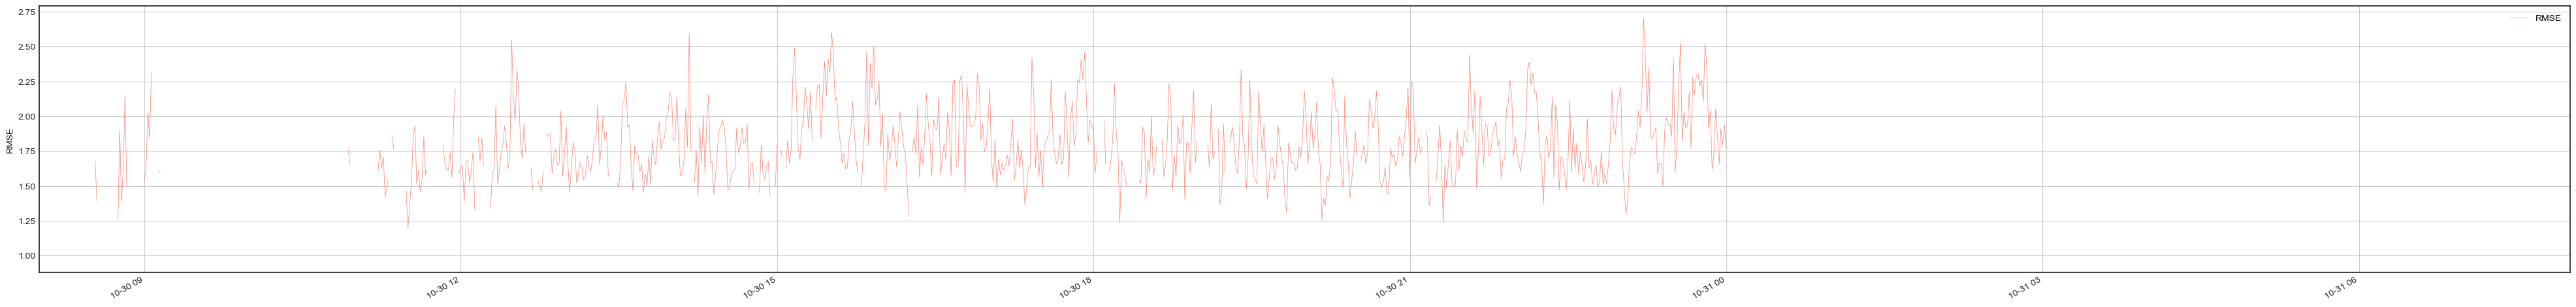

In [204]:
plt.style.use("seaborn-v0_8-white")
plt.figure(figsize=(50,6))
Parsivel_RMSE = plt.plot(df_rmse["rmse"], linewidth = 0.5, label="RMSE", color='salmon')
plt.gcf().autofmt_xdate()
plt.ylabel("RMSE")
plt.legend(labelcolor="black")
plt.grid(True)
plt.xlim([datetime.datetime(2022, 10, 30, 0, 0, 0), 
           datetime.datetime(2022, 10, 31, 0, 0,0)])

plt.show()

In [223]:
pluvioS = pd.read_csv('2023-07-07-13-58_pluvioS.csv', skiprows=3)
pluvioL = pd.read_csv('2023-07-07-13-58_pluvioL.csv', skiprows=3)

pluvioS["_time"] = pd.to_datetime(pluvioS["_time"], format='%Y-%m-%d'+'T'+'%H:%M:%S'+'Z')
pluvioL["_time"] = pd.to_datetime(pluvioL["_time"], format='%Y-%m-%d'+'T'+'%H:%M:%S'+'Z')

pluvioS = pluvioS.set_index("_time")
pluvioL = pluvioL.set_index("_time")

pluvioS = pluvioS.tz_localize('Asia/Taipei')
pluvioL = pluvioL.tz_localize('Asia/Taipei')

pluvioS
pluvioS.loc["2022-10-30 16:51:00+08:00"]

Unnamed: 0                       NaN
result                           NaN
table                              0
_start          2022-10-26T19:00:00Z
_stop           2022-11-02T17:45:00Z
_value                         11.25
_field                          mm/h
_measurement            RT Intensity
Name: 2022-10-30 16:51:00+08:00, dtype: object

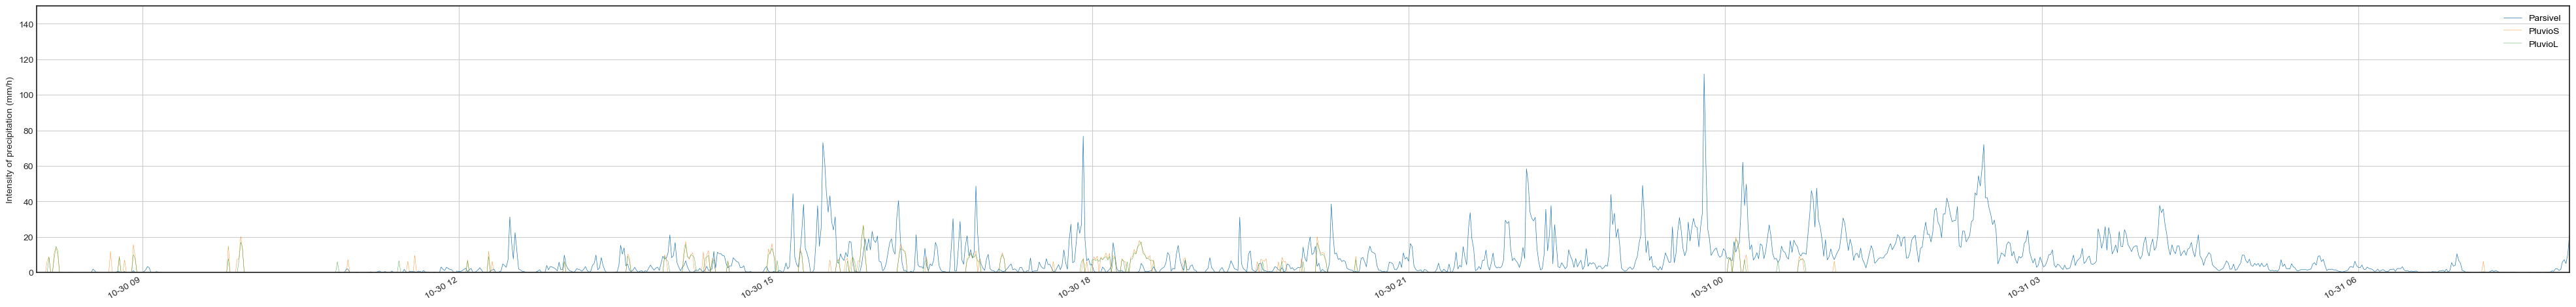

In [205]:
# extract data from certain time period
start_time = "2022-10-27 11:00:00+08:00"
# start_time = "2022-10-30 15:00:00"
end_time = "2022-11-03 09:45:00+08:00"
# end_time = "2022-10-30 16:00:00"
# filt = (data["Date_Time"] >= start_time) & (data["Date_Time"] <= end_time)
# data = data.loc[filt]
# time = data["Date_Time"]
intensity = df["Intensity of precipitation (mm/h)"]
plt.style.use("seaborn-v0_8-white")
plt.figure(figsize=(50,6))
Parsivel_intensity = plt.plot(intensity, linewidth = 0.5, label="Parsivel")
PluvioS_intensity = plt.plot(pluvioS["_value"], linewidth = 0.3, label="PluvioS")
PluvioL_intensity = plt.plot(pluvioL["_value"], linewidth = 0.3, label="PluvioL")
plt.gcf().autofmt_xdate()
plt.ylabel("Intensity of precipitation (mm/h)")
plt.legend(labelcolor="black")
plt.grid(True)
plt.xlim([datetime.datetime(2022, 10, 30, 0, 0, 0), 
           datetime.datetime(2022, 10, 31, 0, 0,0)])
plt.ylim(0, 150)

plt.show()

In [188]:
print(intensity)
print(pluvioL["_value"])

Date_Time
2022-10-10 02:24:00+08:00    0.0
2022-10-10 02:25:00+08:00    0.0
2022-10-10 02:26:00+08:00    0.0
2022-10-10 02:27:00+08:00    0.0
2022-10-10 02:28:00+08:00    0.0
                            ... 
2022-11-15 22:23:00+08:00    0.0
2022-11-15 22:24:00+08:00    0.0
2022-11-15 22:25:00+08:00    0.0
2022-11-15 22:26:00+08:00    0.0
2022-11-15 22:27:00+08:00    0.0
Freq: T, Name: Intensity of precipitation (mm/h), Length: 53044, dtype: float64
_time
2022-10-26 19:01:00+08:00    0.0
2022-10-26 19:02:00+08:00    0.0
2022-10-26 19:03:00+08:00    0.0
2022-10-26 19:04:00+08:00    0.0
2022-10-26 19:05:00+08:00    0.0
                            ... 
2022-11-02 17:41:00+08:00    0.0
2022-11-02 17:42:00+08:00    0.0
2022-11-02 17:43:00+08:00    0.0
2022-11-02 17:44:00+08:00    0.0
2022-11-02 17:45:00+08:00    0.0
Name: _value, Length: 10005, dtype: float64


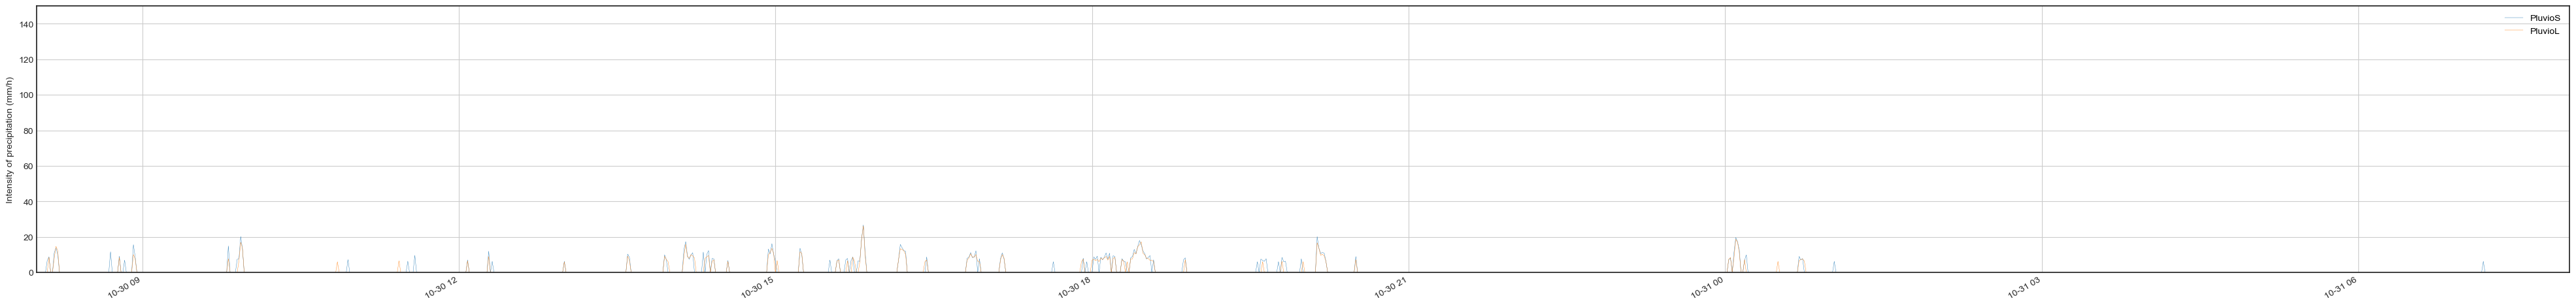

In [207]:
# time = data["Date_Time"]
intensity = df["Intensity of precipitation (mm/h)"]
plt.style.use("seaborn-v0_8-white")
plt.figure(figsize=(50,6))
# Parsivel_intensity = plt.plot(intensity, linewidth = 0.5, label="Parsivel")
PluvioS_intensity = plt.plot(pluvioS["_value"], linewidth = 0.3, label="PluvioS")
PluvioL_intensity = plt.plot(pluvioL["_value"], linewidth = 0.3, label="PluvioL")
plt.gcf().autofmt_xdate()
plt.ylabel("Intensity of precipitation (mm/h)")
plt.legend(labelcolor="black")
plt.grid(True)
plt.xlim([datetime.datetime(2022, 10, 30, 0, 0, 0), 
           datetime.datetime(2022, 10, 31, 0, 0,0)])
plt.ylim(0, 150)

plt.show()

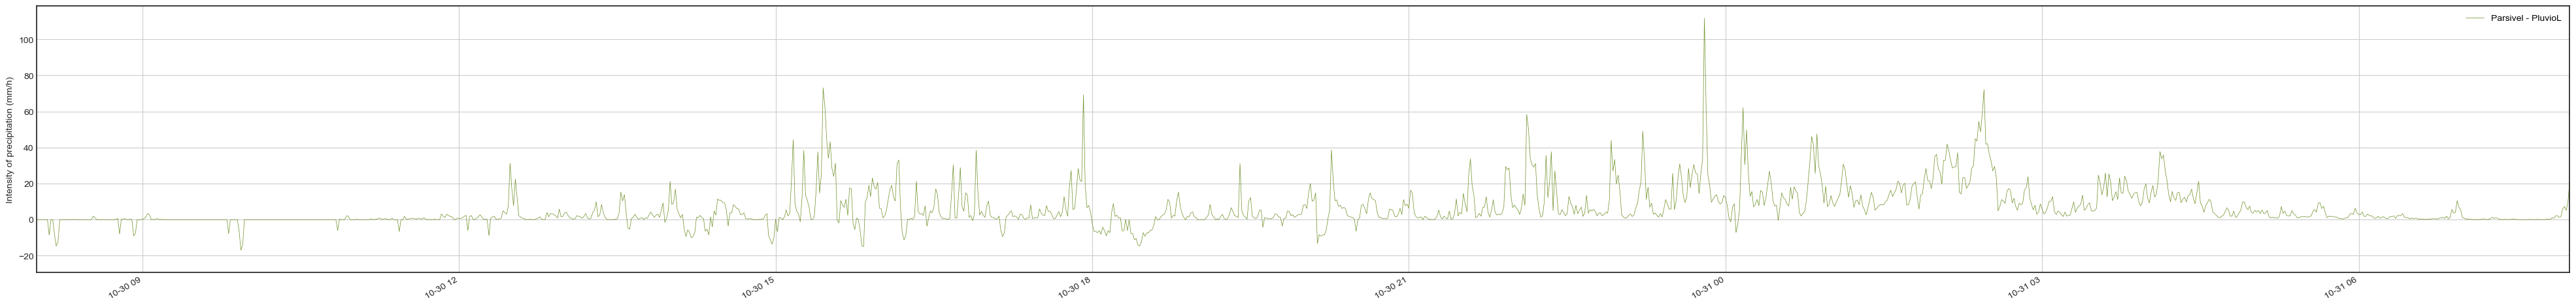

In [197]:
plt.style.use("seaborn-v0_8-white")
plt.figure(figsize=(50,6))
diff = intensity-pluvioL["_value"]
difference = plt.plot(diff, linewidth = 0.5, label="Parsivel - PluvioL", color = 'olivedrab')
plt.gcf().autofmt_xdate()
plt.ylabel("Intensity of precipitation (mm/h)")
plt.legend(labelcolor="black")
plt.grid(True)
plt.xlim([datetime.datetime(2022, 10, 30, 0, 0, 0), 
           datetime.datetime(2022, 10, 31, 0, 0,0)])
# plt.ylim(0, 150)

plt.show()

In [105]:
a = intensity - pluvioL["_value"]
print(a)

2022-10-10 02:24:00   NaN
2022-10-10 02:25:00   NaN
2022-10-10 02:26:00   NaN
2022-10-10 02:27:00   NaN
2022-10-10 02:28:00   NaN
                       ..
10000                 NaN
10001                 NaN
10002                 NaN
10003                 NaN
10004                 NaN
Length: 63049, dtype: float64
